In [175]:
import os
base_path="/content/drive/MyDrive/Applied_Ai_Course/Datasets"
images=os.path.sep.join([base_path,'images'])
annotations=os.path.sep.join([base_path,'airplanes.csv'])

In [176]:
# Lets Load Dataset
# airplanes annotation is a Csv file thats why we can see through with rows

rows= open(annotations).read().strip().split("\n")

# lets make three list where we save our exact bounding boxes
data=[]
targets=[]
filenames=[]

In [177]:
# After load we have to split dataset according to images
# import some usefull libraries
import cv2
from tensorflow.keras.preprocessing.image import load_img
# we also save images into array format so import img_array library too
from tensorflow.keras.preprocessing.image import img_to_array
for row in rows:
  row=row.split(",")
  # we always create rectangle with h+w so we have to know where exactly we should start from
  (filename,startX,startY,endX,endY)=row

  imagepaths=os.path.sep.join([images,filename])
  image=cv2.imread(imagepaths)
  (h,w)=image.shape[:2]

  # initializing starting point
  # Why we take in float because when we convert into array so then will trouble happen
  startX = float(startX) / w
  startY = float(startY) / h
  # Also initialize ending point 
  endX = float(endX) / w
  endY = float(endY) / h
  #load image and give them default size
  image=load_img(imagepaths,target_size=(224,224))
  # see here if we cant take it into float then we face trouble 
  image=img_to_array(image)

  # Lets append into data , targets ,filenames
  targets.append((startX,startY,endX,endY))
  filenames.append(filename)
  data.append(image)


In [178]:
# Normalizing Data here also we face would face issues if we take input as integer
import numpy as np
data=np.array(data,dtype='float32') / 255.0
targets=np.array(targets,dtype='float32')

In [179]:
# we should seperate data into train and split so import sklearn library 
from sklearn.model_selection import train_test_split

In [180]:
# split into testing and training
split=train_test_split(data,targets,filenames,test_size=0.10,random_state=42)

In [181]:
# lets split into steps
(train_images,test_images) = split[:2]
(train_targets,test_targets) = split[2:4]
(train_filenames,test_filenames) = split[4:]


In [182]:
# lets import pre trained VGG16 Which is already Builtin for computer vision
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input

In [183]:
# Imagenet is a competition every year held and VGG16 is winner of between  2013-14
# so here we just want limited layers so thats why we false included_top 
vgg=VGG16(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

In [184]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [185]:
from tensorflow.keras.layers import Input,Flatten,Dense

In [186]:
# we use VGG16 as per our requirement not use whole 
vgg.trainable = False

flatten = vgg.output

flatten = Flatten()(flatten)

In [187]:
# Lets make bboxhead
bboxhead = Dense(128,activation="relu")(flatten)
bboxhead = Dense(64,activation="relu")(bboxhead)
bboxhead = Dense(32,activation="relu")(bboxhead)
bboxhead = Dense(4,activation="relu")(bboxhead)

In [188]:
# lets import Model
from tensorflow.keras.models import Model
model = Model(inputs = vgg.input,outputs = bboxhead)

In [189]:
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [190]:
# Lets fit our model 
# Optimization 
from tensorflow.keras.optimizers import Adam

opt = Adam(1e-4)

In [191]:
model.compile(loss='mse',optimizer=opt)

In [192]:
history = model.fit(train_images,train_targets,validation_data=(test_images,test_targets),batch_size=32,epochs=50,verbose=1)

Epoch 1/50
23/23 [==============================] - 4s 155ms/step - loss: 0.0342 - val_loss: 0.0186
Epoch 2/50
23/23 [==============================] - 3s 152ms/step - loss: 0.0124 - val_loss: 0.0080
Epoch 3/50
23/23 [==============================] - 4s 153ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 4/50
23/23 [==============================] - 4s 155ms/step - loss: 0.0061 - val_loss: 0.0066
Epoch 5/50
23/23 [==============================] - 4s 155ms/step - loss: 0.0057 - val_loss: 0.0064
Epoch 6/50
23/23 [==============================] - 3s 151ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 7/50
23/23 [==============================] - 3s 148ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 8/50
23/23 [==============================] - 3s 147ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 9/50
23/23 [==============================] - 3s 146ms/step - loss: 7.5519e-04 - val_loss: 0.0020
Epoch 10/50
23/23 [==============================] - 3s 142ms/step - loss: 6.2409e-04 - val_loss

In [228]:
# lets save model 
model.save('detect_Planes.h5')

In [229]:
from tensorflow.keras.models import load_model

In [230]:
model=load_model('/content/detect_Planes.h5')

In [231]:
imagepath='/content/drive/MyDrive/Applied_Ai_Course/Datasets/images/image_0111.jpg'

In [232]:
image = load_img(imagepath,
                 target_size=(224,224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image,axis=0)

In [233]:
preds=model.predict(image)[0]
(startX,startY,endX,endY)=preds

In [234]:
import imutils

In [235]:
image=cv2.imread(imagepaths)
image=imutils.resize(image,width=600)

In [236]:
(h,w)=image.shape[:2]

In [237]:
startX=int(startX * w)
startY=int(startY * h)

endX=int(endX * w)
endY=int(endY * h)

In [238]:
cv2.rectangle(image,(startX,startY),(endX,endY),(0,255,0),3)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [239]:

from google.colab.patches import cv2_imshow


-1

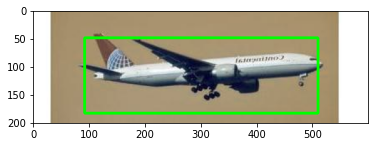

In [240]:
import matplotlib.pyplot as plt
plt.imshow(image)
cv2.waitKey(0)